In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import matplotlib as mpl
from mpltools import annotation
import time

from matplotlib import rc
import seaborn as sns
custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.3,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif",
}

sns.set_theme(context = "notebook", style="ticks", rc=custom_params)

BlueUB = (0, 157/255, 224/255)
BrownUB = (68/255, 58/255, 49/255)

## Instance of the Langevin class and trajectory calculation

In [3]:
from Overdamped_Langevin import Langevin

tc_0 = time.time() 
brown = Langevin(dt=0.01, Nt=100_000, a=1.5e-6) #Création d'une instance de classe Langevin
brown.trajectory() #Invocation de la méthode trajectory() pour calculer la trajectoire de la particule
print("Compute time= ", time.time()-tc_0)

Compute time=  42.98791432380676


## Standard deviation $\langle X_n^2 \rangle$

In [5]:
delta_t, msd = brown.MSD() #Invocation de la méthode MSD pour calculer la déviation standard de la trajectoire
dt_theo = np.linspace(brown.dt*1e-1, brown.dt*brown.Nt*1e1, 100)

## Deplacements distribution P($\Delta X_n$)

In [7]:
N_tau = 10
sigma = np.sqrt(2*brown.D0*N_tau*brown.dt)
delta_Xtau = brown.Xn[N_tau:]-brown.Xn[:-N_tau]
x = np.linspace(-5* sigma, 5 * sigma, 1000)
p_gauss = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-x ** 2 / (2 * sigma ** 2))

## Figures

### 1) Trajectrory

Text(0, 0.5, '$X_n$')

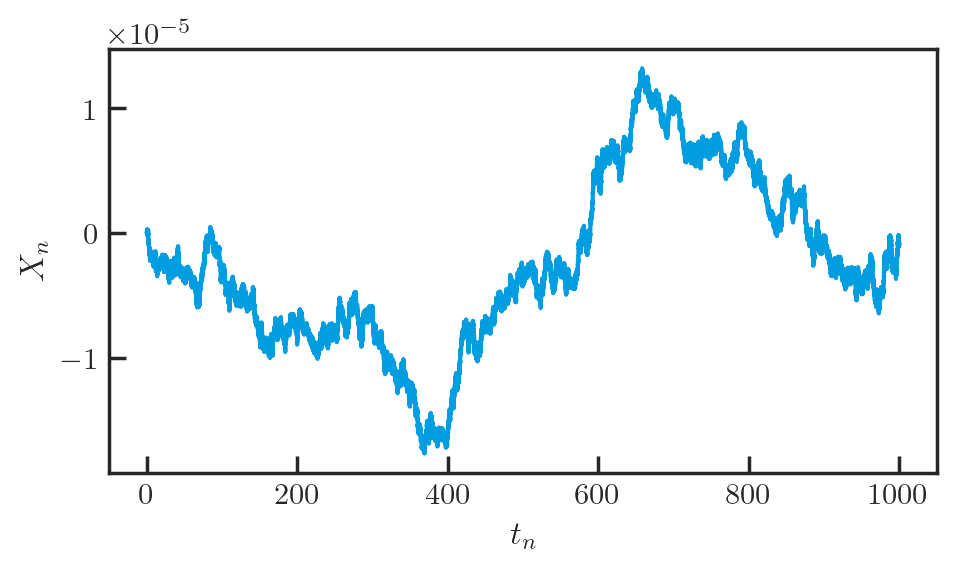

In [14]:
plt.figure(figsize=(1.5 * 3.375, 1.5 * 3.375 / 1.68), tight_layout=True)
plt.plot(brown.t, brown.Xn, color=BlueUB)
plt.xlabel(r"$t_n$")
plt.ylabel(r"$X_n$")
plt.savefig("Trajectoire.pdf")

### 2) $\langle X_n^2 \rangle$ and P($\Delta X_n$)

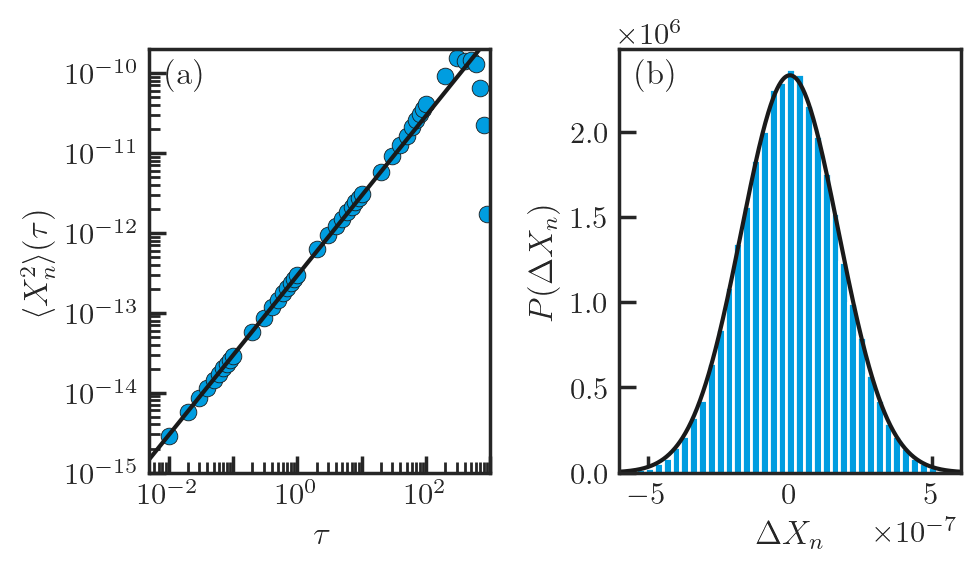

In [13]:
plt.figure(figsize=(1.5 * 3.375, 1.5 * 3.375 / 1.68), tight_layout=True)

ax1 = plt.subplot(121)
ax1.loglog(delta_t, msd, "o", color=BlueUB)
ax1.plot(dt_theo, 2*brown.D0*dt_theo, "k-")
ax1.set(
    xlabel = r"$\tau$",
    ylabel = r"$\langle X_n^2 \rangle(\tau)$",
    xlim=(brown.dt/2, brown.dt*brown.Nt),
    ylim=(1e-15, 2e-10),
    xticks = (1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3),
)
ax1.text(0.05, 0.92, r"(a)", transform=ax1.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax1_ticks = ax1.get_xticklabels()
for i in ax1_ticks:
    i.set_visible(False)
for n, i in enumerate(ax1_ticks):
    if n%2==0:i.set_visible(True)


ax2 = plt.subplot(122)
ax2.hist(delta_Xtau, bins=50, density=True, color=BlueUB)
ax2.plot(x, p_gauss / np.trapz(p_gauss, x), "k-")
ax2.set(
    xlabel = r"$\Delta X_{n}$", 
    ylabel = r"$P(\Delta X_{n})$",
    xlim = (-6e-7,6e-7),
)
ax2.text(0.05, 0.92, r"(b)", transform=ax2.transAxes)

plt.savefig("Annalyse.pdf")